# Jonathan Cauchi - 52197870 - Assignment 2 

### Required libraries

To run the notebook, you will need **Standford OpenIE** Python3 wrapper. To install, enter following command in terminal:

***pip install stanford_openie***

**The library only runs on Linux and Mac machines**

In [6]:
import requests
import spacy
import networkx as nx
import matplotlib.pyplot as plt
import copy
from bs4 import BeautifulSoup
from openie import StanfordOpenIE
from rdflib import Graph, URIRef, RDF

## Scraping text from web articles using **BeautifulSoup**.

### For this assignment, web articles related to covid-19 vaccines were considered. All the p tags containing the body of the text were extracted from the HTML of the pages. The text is then segmented into sentences, and only the sentences containing an instance of either ***covid*** or ***vaccine*** are kept.

In [2]:
nlp = spacy.load("en_core_web_sm")
sentenceList = []
url_list = ["https://www.who.int/emergencies/diseases/novel-coronavirus-2019/covid-19-vaccines"]

for url in url_list:
    page = requests.get(url)
    soup = BeautifulSoup(page.text, "html.parser")
    for objects in soup.findAll("p"):
        objects = objects.get_text().lower()
        objects = nlp(objects)
        for sentence in objects.sents:
            if "vaccine" or "covid" in str(sentence):
                print(sentence)
                print("------")

the world is in the midst of a covid-19 pandemic.
------
as who and partners work together on the response -- tracking the pandemic, advising on critical interventions, distributing vital medical supplies to those in need--- they are racing to develop and deploy
    safe and effective vaccines. 
------
vaccines save millions of lives each year.
------
vaccines work by training and preparing the body’s natural defences --- the immune system--- to recognize and fight off the viruses and bacteria they target.
------
after vaccination, if the body is later exposed to those disease-causing
    germs, the body is immediately ready to destroy them, preventing illness.
------
as of 18 february 2021, at least seven different vaccines across three platforms have been rolled out in countries.
------
vulnerable populations in all countries are the highest priority for vaccination.
------
at the same time, more than 200 additional vaccine candidates are in development, of which more than 60 are in 

## Converting sentences into triples using **Standford OpenIE** 

The above process is repeated, but this time for 6 articles. After all the relevant sentences are extracted, the sentences are passed through the Stanford OpenIE pipeline where then they will be converted into triples.

After all the triples are constructed, they are filtered further by removing all triples that do not contain an instance of either ***covid*** or ***vaccine*** in the entities.

In [3]:
nlp = spacy.load("en_core_web_sm")
sentenceList = []
url_list = ["https://www.health.pa.gov/topics/programs/immunizations/Pages/COVID-19-Vaccine-Providers.aspx","https://www.abpi.org.uk/medicine-discovery/covid-19/what-are-pharmaceutical-companies-doing-to-tackle-the-disease/#916ad4c7","https://www.who.int/emergencies/diseases/novel-coronavirus-2019/covid-19-vaccines","https://www.aberdeencity.gov.uk/services/coronavirus-covid-19/nhs-grampian-covid-19-vaccinations","https://www.aberdeencity.gov.uk/services/coronavirus-covid-19/shielding-covid-19-vaccine","https://www.ema.europa.eu/en/human-regulatory/overview/public-health-threats/coronavirus-disease-covid-19/treatments-vaccines/vaccines-covid-19/covid-19-vaccines-key-facts"]
with StanfordOpenIE() as client:
    for url in url_list:
        page = requests.get(url)
        soup = BeautifulSoup(page.text, "html.parser")
        with StanfordOpenIE() as client:
            for objects in soup.findAll("p"): #extracting all content inside p tags
                objects = objects.get_text().lower()
                objects = nlp(objects)
                for sentence in objects.sents:
                    if "vaccine" in str(sentence) or "covid" in str(sentence):
                        for triple in client.annotate(str(sentence)):
                            if(("covid" in triple["subject"] or "covid" in triple["object"])or("vaccine" in triple["subject"] or "vaccine" in triple["object"])):
                                sentenceList.append(triple)
                    else:
                        continue

Starting server with command: java -Xmx8G -cp /home/jonat/stanfordnlp_resources/stanford-corenlp-full-2018-10-05/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-aedf56edeac545e8.props -preload openie
Starting server with command: java -Xmx8G -cp /home/jonat/stanfordnlp_resources/stanford-corenlp-full-2018-10-05/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-033c9846963241cd.props -preload openie
Starting server with command: java -Xmx8G -cp /home/jonat/stanfordnlp_resources/stanford-corenlp-full-2018-10-05/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-1f9029a1cdbe4797.props -preload openie
Starting server with command: java -Xmx8G -cp /home/jonat/stanfordnlp_resources/st

Exception ignored in: <function StanfordOpenIE.__del__ at 0x7f362ffdad40>
Traceback (most recent call last):
  File "/home/jonat/anaconda3/lib/python3.7/site-packages/openie/openie.py", line 90, in __del__
    del os.environ['CORENLP_HOME']
  File "/home/jonat/anaconda3/lib/python3.7/os.py", line 695, in __delitem__
    raise KeyError(key) from None
KeyError: 'CORENLP_HOME'


## Let's take a look at some of the triples

In [4]:
print("-------------")
print("Number of triples is: {}".format(len(sentenceList)))
print("-------------")
print("Some triples:")
print("-------------")
sentenceList[-5:-1]

-------------
Number of triples is: 649
-------------
Some triples:
-------------


[{'subject': 'vaccines',
  'relation': 'require',
  'object': 'much lower temperatures'},
 {'subject': 'viral-vectored vaccines',
  'relation': 'require',
  'object': 'lower temperatures'},
 {'subject': 'viral-vectored vaccines',
  'relation': 'require',
  'object': 'much lower temperatures'},
 {'subject': 'mrna vaccines',
  'relation': 'require',
  'object': 'lower temperatures'}]

# Mapping the entities to vocabularies

For this task, the text of the entities in our triples are concatonated with the **https://dbpedia.org/page** namespace. Once all entities are assigned a namespace, the next step is to verify which URLs are valid and not valid. To do this, Beautifulsoup was used once more to scrape the text from all the URLs. The URLs which return the text ***no further information available...*** are given an example URI Namespace **https://example.org**. This cell will take a few minutes to execute.

In [8]:
triples = copy.deepcopy(sentenceList)
ex = "https://dbpedia.org/page/"
#mapping URI's to entities
for dictionary in triples:
    subject = dictionary["subject"].lower()
    temp_sub = subject[1:]
    upper_sub = subject[0].upper()
    string_sub = upper_sub + temp_sub
    final = ex + string_sub
    dictionary["subject"] = final
    
    obj = dictionary["object"].lower()
    temp_obj = obj[1:]
    upper_obj = obj[0].upper()
    string_obj = upper_obj + temp_obj
    final_obj = ex + string_obj
    dictionary["object"] = final_obj
    
urls_list = []
for dictionary in triples:
    urls_list.append(dictionary["subject"])
    urls_list.append(dictionary["object"])
urls_list = set(urls_list)
bad_url = []
for url in urls_list:
    page = requests.get(url)
    soup = BeautifulSoup(page.text, "html.parser")
    for objects in soup.findAll("p"):
            objects = objects.get_text().lower()
            #print(objects)
            if(objects == "no further information is available. (the requested entity is unknown)"):
                bad_url.append(url)
            else:
                continue
                
#we iterate through our triples, if we find a value that corresponds to a bad url, we replace that value with an example namespace URL
bad_ex = "http://example.org/"
for dictionary in triples:
    for url in bad_url:
        if(dictionary["subject"] == url): 
            string = dictionary["subject"][25:]
            dictionary["subject"] = bad_ex + string
        elif(dictionary["object"] == url):
            string = dictionary["object"][25:]
            dictionary["object"] = bad_ex + string
            
ex = "https://dbpedia.org/page/"
for triple in triples:
    a = triple["relation"].split(" ") #here we split the relation into words
    string = a[0] #we take the first word from relations key
    temp_rel = string[1:] 
    upper_rel = string[0].upper() #capitalizing 1st char
    string_rel = upper_rel + temp_rel
    final_rel = ex + string_rel #adding relations value to dpedia namespace
    triple["relation"] = final_rel 


### Triples after mapping

In [9]:
triples[-5:-1]

[{'subject': 'https://dbpedia.org/page/Vaccines',
  'relation': 'https://dbpedia.org/page/Require',
  'object': 'http://example.org/Much lower temperatures'},
 {'subject': 'http://example.org/Viral-vectored vaccines',
  'relation': 'https://dbpedia.org/page/Require',
  'object': 'http://example.org/Lower temperatures'},
 {'subject': 'http://example.org/Viral-vectored vaccines',
  'relation': 'https://dbpedia.org/page/Require',
  'object': 'http://example.org/Much lower temperatures'},
 {'subject': 'http://example.org/Mrna vaccines',
  'relation': 'https://dbpedia.org/page/Require',
  'object': 'http://example.org/Lower temperatures'}]

## Visualization

Here we visualize a graph consiting of the first ten triples in our list. 

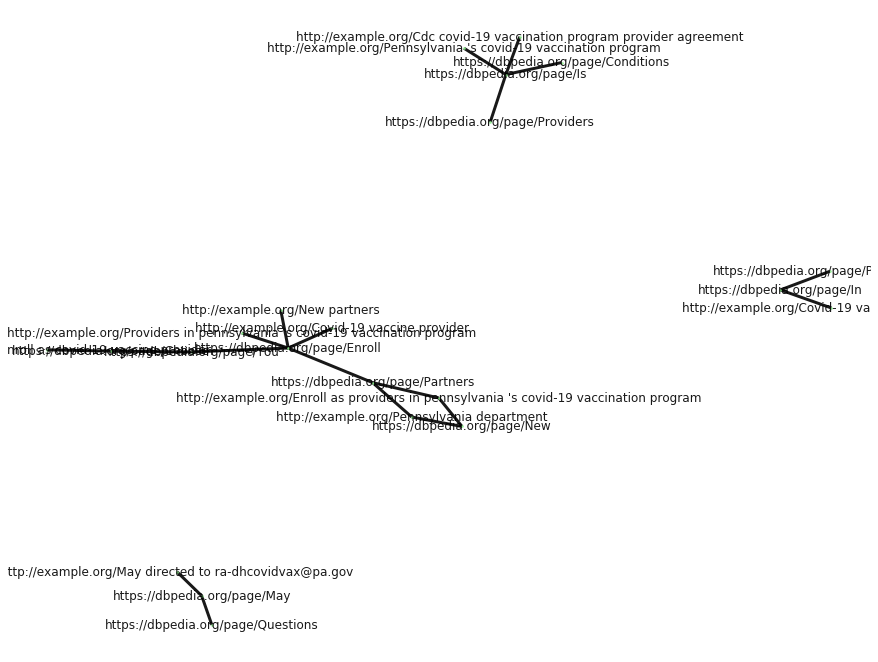

In [10]:
#Visualizing a graph of the 1st 10 triples
list = []
for i in range(0,10):
    list.append(triples[i])
    
G = nx.Graph()
for triple in list:
    G.add_node(triple["subject"])
    G.add_node(triple["relation"])
    G.add_node(triple["object"])
    G.add_edge(triple["subject"], triple["relation"])
    G.add_edge(triple["relation"], triple["object"])

pos = nx.spring_layout(G)
plt.figure(figsize=(12,9))
nx.draw(G, pos, edge_color='black', width=3,linewidths=0.5,
        node_size=4,node_color='lightgreen', alpha=0.9,
        labels={node: node for node in G.nodes()})
plt.axis('off')
plt.show()

## Creating the Covid19 Knowledge Graph using ***rdflib***

Next step is to create our RDF Knowledge Graph. Given **rdflib** does not accept example URLs, we only add the triples that contain only **dbpedia** URLs. Ideally more time would have been spent in assinging valid URLs to most if not all the triples, but that would have been quite the challenge with the limited time available.

In [11]:
g = Graph()
triples_list = []
for i in triples:
     if "example" not in i["subject"] and "example" not in i["object"]:
         triples_list.append(i)     
for triple in triples_list:
    g.add((URIRef(triple["subject"]), URIRef(triple["relation"]), URIRef(triple["object"])))
g.serialize(destination='turtle.txt', format='turtle')
g.serialize(destination='ntriple.txt', format='nt')

## For the querying tasks, GraphDB was used. The queries and outputs are in the PDF report provided with this notebook